In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Calibrate camera

Camera is already calibrated
Matrix: [[  1.15621342e+03   0.00000000e+00   6.77848443e+02]
 [  0.00000000e+00   1.15212459e+03   3.74188890e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Dist: [[ -2.66350145e-01   5.82180825e-02  -1.33269041e-03   6.34592536e-05
   -1.22904379e-01]]


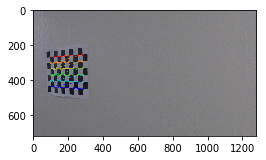

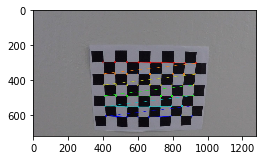

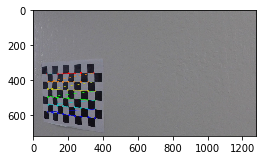

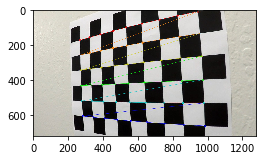

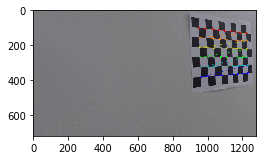

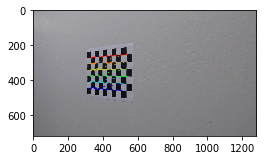

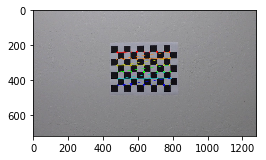

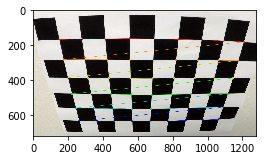

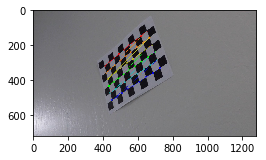

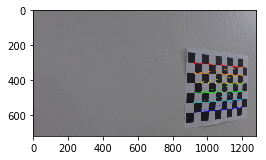

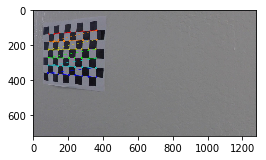

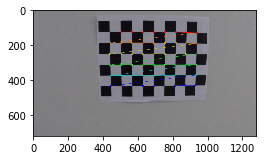

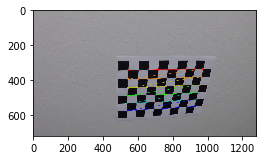

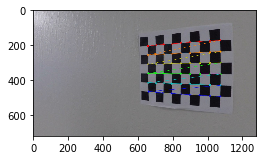

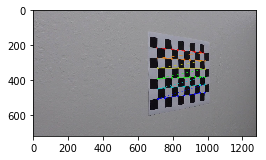

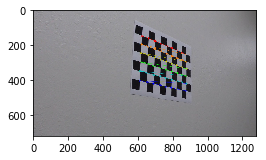

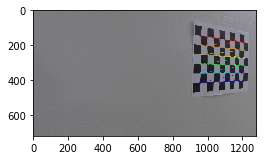

In [2]:
%matplotlib inline

camera_calibrated = False
try:
    dist_pickle = pickle.load(open('camera_coeff.p', 'rb'))
    mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]
    camera_calibrated = True
    print('Camera is already calibrated')
    print('Matrix:', mtx)
    print('Dist:', dist)
except Exception as e:
    print(e)


if not camera_calibrated:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    failure = []
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        thresh = 80
        thresh_img = np.copy(gray)
        thresh_img[thresh_img < thresh] = 0
        thresh_img[thresh_img > thresh] = 255

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(thresh_img, (9,6), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            img_name = fname.split('/')[-1]
            cv2.imwrite('output_images/chessboardcorners/' + img_name, img)
        else:
            failure.append(fname)
    print(failure)
    
output_images = glob.glob('output_images/chessboardcorners/calibration*.jpg')
for fname in output_images:
    img = plt.imread(fname)
    plt.figure(figsize = (4, 4))
    plt.imshow(img, cmap = 'gray')


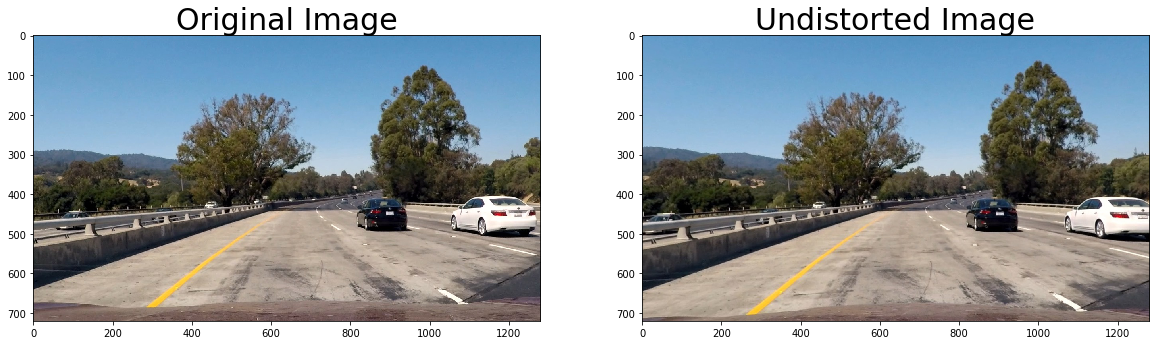

In [3]:
# Test undistortion on an image
test_img = cv2.imread('test_images/test1.jpg')

if not camera_calibrated:
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img.shape[:2][::-1],None,None)
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/straight_lines1_undist.jpg', dst)

    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open( "camera_coeff.p", "wb" ) )
else:
    dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/test1_undist.jpg', dst)

dst = plt.imread('output_images/test1_undist.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline

## Undistortion

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Perspective Transform

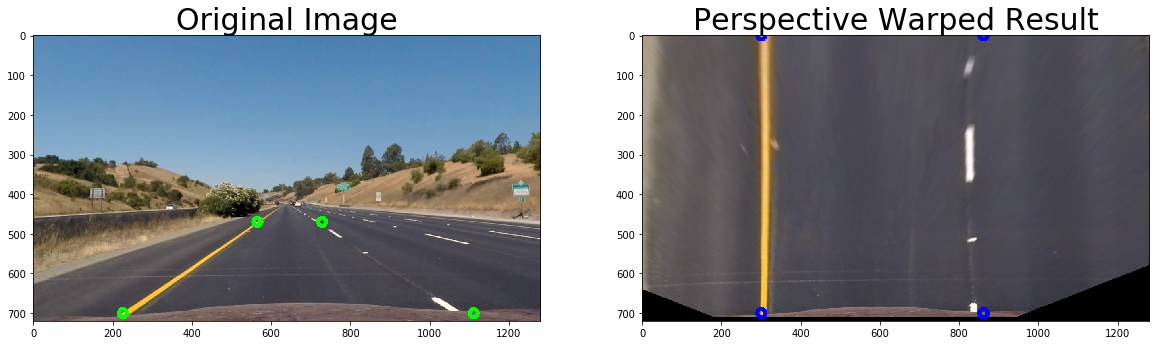

In [19]:
%matplotlib inline

source_points = np.float32([(565, 470), (728, 470), (1110, 700), (226, 700)])
destination_points = np.float32([(300, 0), (860, 0), (860,700), (300, 700)])
    
# Perspective transform the image to view the lane lines from above
def perspectiveWarp(img, srcpts, dstpts, visual = False):
    M = cv2.getPerspectiveTransform(srcpts, dstpts)
    warped = cv2.warpPerspective(img, M, img.shape[:2][::-1], flags=cv2.INTER_LINEAR)
    return warped

test_img = undistort(plt.imread('test_images/straight_lines1.jpg'), mtx, dist)
warped = perspectiveWarp(test_img, source_points, destination_points)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot mappings
for pts in source_points:
    cv2.circle(test_img, tuple(pts), 10, [0, 255, 0], 10)
for pts in destination_points:
    cv2.circle(warped, tuple(pts), 10, [0, 0, 255], 10)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(warped)
ax2.set_title('Perspective Warped Result', fontsize=30)

try:
    open('output_images/perspective_warp.jpg')
except:
    f.savefig('output_images/perspective_warp.jpg')

## Binary Warp

### Utils and Prepare Variables

In [24]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def within(val, thresh):
    return (val >= thresh[0]) & (val <= thresh[1])

def threshold(binary, channel, thresh, logic_op = np.logical_or):
    black = np.zeros(channel.shape)
    black[within(channel, thresh)] = 1
    res = logic_op(binary.squeeze(), black.squeeze())
    return np.uint8(res)

def plot_channel(channel, name, thresh, black = None):
    # plot the given channel, and the thresholded binary image
    if not black:
        black = np.zeros(pers.shape[:2])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(channel.squeeze(), cmap = 'gray')
    ax1.set_title('{} Channel'.format(name), fontsize=fnt)
    ax2.imshow(threshold(black, channel, thresh), cmap = 'gray')
    ax2.set_title('{} Binary'.format(name), fontsize=fnt)
    
def plugQuad(fitx, y):
    return np.sum(np.multiply(fitx, [y ** 2, y, 1]), axis = 0)
    
DEFAULT_REGION = np.int_([[(250, 0), (950, 0), (950,700), (250, 700)]])
def region_of_interest(img, vertices = DEFAULT_REGION):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def lane_width(left_fit, right_fit, max_y):
    leftx = plugQuad(left_fit, max_y)
    rightx = plugQuad(right_fit, max_y)
    width = rightx - leftx
    return width * xm_per_pix

test_fname = 'test_images/test1.jpg'

test_img = undistort(plt.imread(test_fname), mtx ,dist)
pers = perspectiveWarp(test_img, source_points, destination_points)
pers = region_of_interest(pers)

### Explore color channels

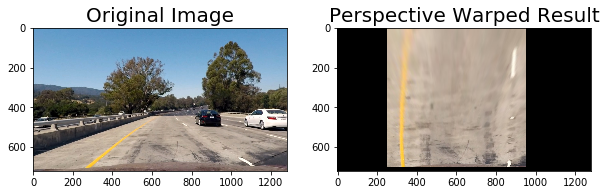

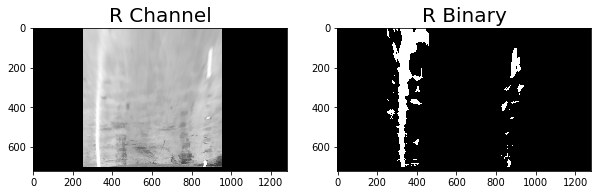

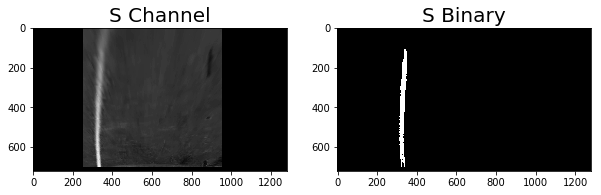

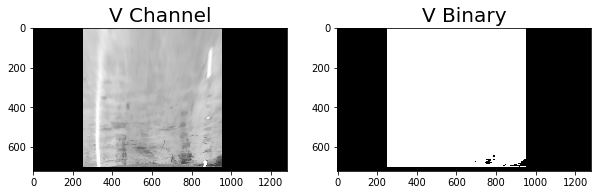

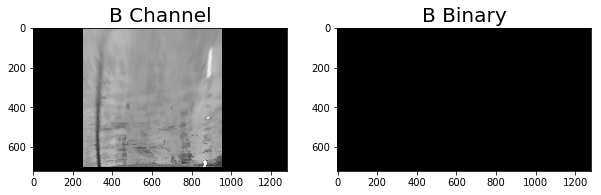

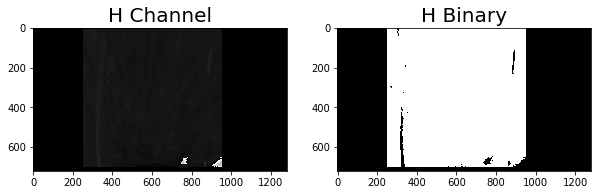

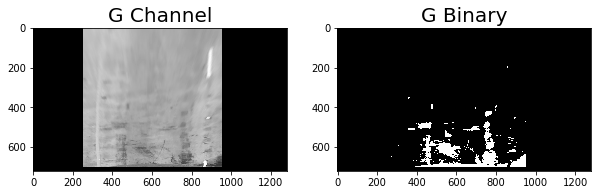

In [25]:
r, g, b = np.split(pers, 3, axis = 2)
h, s, v = np.split(cv2.cvtColor(pers, cv2.COLOR_RGB2HSV), 3, axis = 2)
fnt = 20

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=fnt)
ax2.imshow(pers)
ax2.set_title('Perspective Warped Result', fontsize=fnt)

channel_name = ['R', 'S', 'V', 'B', 'H', 'G']
channels = [r, s, v, b, h, g]
threshs = [(210, 255), (100, 200), (100, 255), (15, 30), (5, 20), (10, 150)]
for channel, name, thresh in zip(channels, channel_name, threshs):
    plot_channel(channel, name, thresh)

### Explore gradients

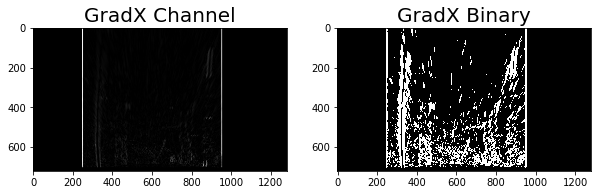

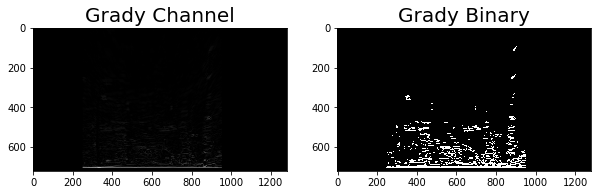

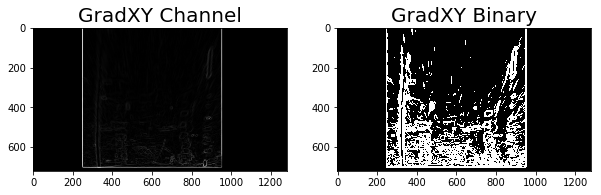

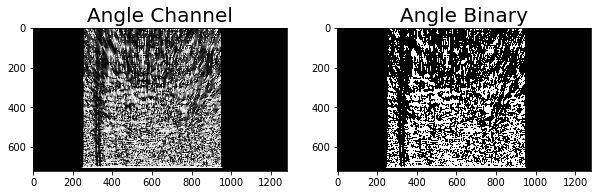

In [26]:
## apply Sobel
kernel = 13
sobelx = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize = kernel) # Take the derivative in x
sobely = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize = kernel)
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_x = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))

abs_sobely = np.absolute(sobely)
scaled_y = np.uint8(255 * abs_sobely/np.max(abs_sobely))

angle = np.arctan2(abs_sobely, abs_sobelx)
abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
scaled_xy = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))

channels = [scaled_x, scaled_y, scaled_xy, angle]
threshs = [(5, 255), (10, 255), (5, 255), (0.8, 1.6)]
channel_name = ['GradX', 'Grady', 'GradXY', 'Angle']

for channel, name, thresh in zip(channels, channel_name, threshs):
    plot_channel(channel, name, thresh)

### Full line filter

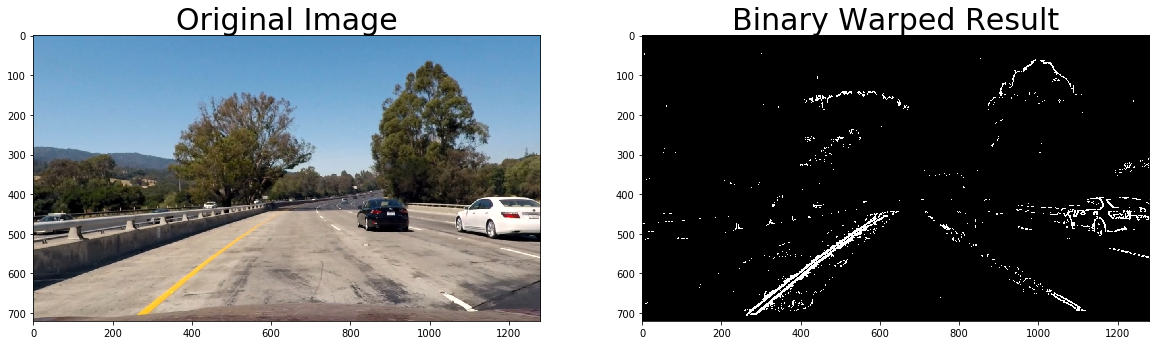

In [30]:
LINE_FILTER = {
    's_thresh': (100, 200),
    'h_thresh': (5, 20),
    'b_thresh': (15, 30),
    'sx_thresh': (5, 255), 
    'sy_thresh': (5, 150), 
    'mag_thresh': (10, 250), 
    'dir_thresh': (0.3, 1.6),
    'r_thresh': (204, 255),
    'v_thresh': (100, 255)
}

# binary warp the image to make the lane lines clear
def binaryWarp(img, kernel = 13, lfilter = LINE_FILTER):
    r_thresh = lfilter['r_thresh']
    v_thresh = lfilter['v_thresh']
    s_thresh = lfilter['s_thresh']
    b_thresh = lfilter['b_thresh']
    h_thresh = lfilter['h_thresh']
    sx_thresh = lfilter['sx_thresh']
    sy_thresh = lfilter['sy_thresh']
    mag_thresh = lfilter['mag_thresh']
    dir_thresh = lfilter['dir_thresh']

    r_channel = img[:, :, 0]
    b_channel = img[:, :, 2]

    # Convert to HLS color space and separate the V S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hls[:, :, 0]
    v_channel = hls[:,:,2]
    s_channel = hls[:,:,1]

    # apply Sobel
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0, ksize = kernel) # Take the derivative in x
    sobely = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1, ksize = kernel)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    abs_sobely = np.absolute(sobely)
    scaled_y = np.uint8(255*abs_sobely/np.max(abs_sobely))

    angle = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros(scaled_x.shape)
    
    # threshold on r_channel, which detects white line well
    binary_output[
        within(r_channel, r_thresh)
    ] = 1
    
    # threshold on s_channel, which detects yellow lines well
    binary_output[
        within(s_channel, s_thresh)
    ] = 1

    # threshold on sobelx, with very low min, so that we catch most reasonable changes
    # the operations above filter out the noises in sobelx
    # also threshold on v_channel to avoid shadowy shapes
    binary_output = np.logical_and(
        binary_output, within(scaled_x, sx_thresh) & within(v_channel, v_thresh)
    )

    return np.uint8(binary_output)

warped = binaryWarp(test_img)

# Plot the binary warped result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(warped, cmap = 'gray')
ax2.set_title('Binary Warped Result', fontsize=30)

## Fit polynomial using convolutions

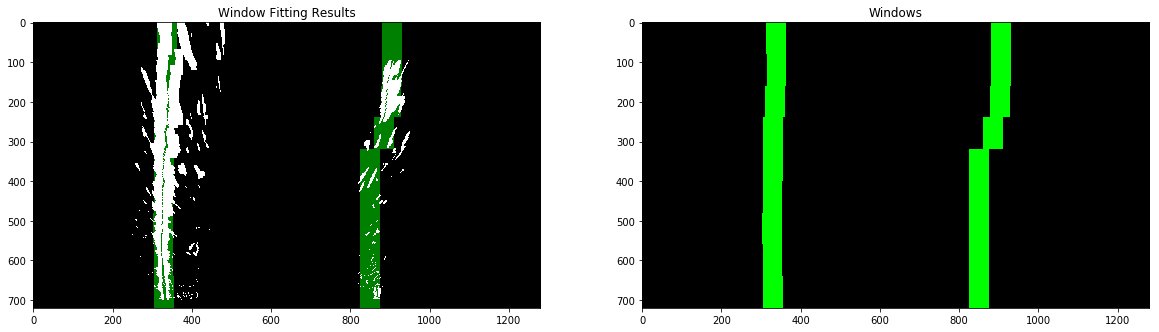

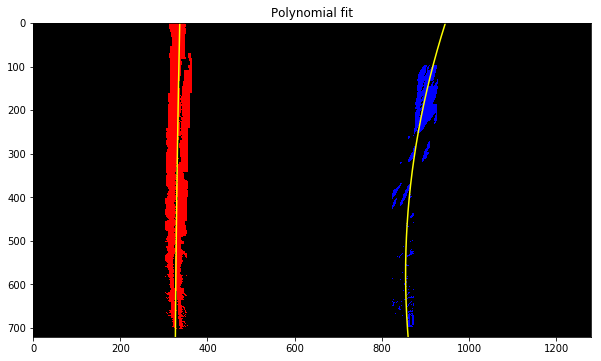

In [33]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
min_pixels = 500

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[
        int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
        max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])
    ] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin, min_pixels, ratio_bottom):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum a ratio of the image
    l_sum = np.sum(image[int((1 - ratio_bottom)*image.shape[0]):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int((1 - ratio_bottom)*image.shape[0]):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        max_l_ind = np.argmax(conv_signal[l_min_index: l_max_index]) + l_min_index
        # Check if we have enough number of pixels to adjust the window
        if conv_signal[max_l_ind] >= min_pixels:
            l_center = max_l_ind -offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        max_r_ind = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index
        if conv_signal[max_r_ind] >= min_pixels:
            r_center = max_r_ind - offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def centroids_to_windows(window_centroids, warped, window_width, window_height):
    # Points used to draw all the left and right windows
    l_windows = np.zeros_like(warped)
    r_windows = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_windows[(l_mask == 1)] = 1
        r_windows[(r_mask == 1)] = 1
    return l_windows, r_windows

def windows_to_curves(l_windows, r_windows, warped):
    l_nonzero = np.zeros_like(warped)
    l_nonzero[
        (l_windows == 1) & (warped > 0)
    ] = 1
    l_nonzero = l_nonzero.nonzero()
    r_nonzero = np.zeros_like(warped)
    r_nonzero[
        (r_windows == 1) & (warped > 0)
    ] = 1
    r_nonzero = r_nonzero.nonzero()

    leftx = l_nonzero[1]
    lefty = l_nonzero[0]
    left_fit = np.polyfit(lefty, leftx, 2)

    rightx = r_nonzero[1]
    righty = r_nonzero[0]
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, l_nonzero, r_nonzero
    
warped = binaryWarp(test_img)
warped = perspectiveWarp(warped, source_points, destination_points)
warped = region_of_interest(warped)
window_centroids = find_window_centroids(warped, window_width, window_height, margin, min_pixels, 1.0 / 2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

# If we found any window centers
if len(window_centroids) > 0:
    l_windows, r_windows = centroids_to_windows(window_centroids, warped, window_width, window_height)
    # Draw the results
    template = np.array(r_windows + l_windows,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) * 255 # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(np.uint8(warpage), 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    ax2.imshow(template)
    ax2.set_title('Windows')
    
    left_fit, right_fit, l_nonzero, r_nonzero = windows_to_curves(l_windows, r_windows, warped)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = plugQuad(left_fit, ploty)
    right_fitx = plugQuad(right_fit, ploty)

    out_img = np.zeros(warped.shape[:2] + (3,), dtype = np.uint8)
    out_img[l_nonzero[0], l_nonzero[1]] = [255, 0, 0]
    out_img[r_nonzero[0], r_nonzero[1]] = [0, 0, 255]

    f = plt.figure(figsize = (10, 10))
    plt.gca().set_title('Polynomial fit')
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    line_points = np.array((np.vstack((left_fitx, ploty)).T, np.vstack((right_fitx, ploty)).T), dtype=np.int32)
    cv2.polylines(out_img, line_points, False, [255, 255, 0], thickness=2, lineType=cv2.LINE_AA)

 
# If no window centers found, just display orginal road image
else:
    print('No Windows Found')
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

cv2.imwrite('output_images/fit_output.jpg', out_img[:, :, ::-1])
# Display the final results
ax1.imshow(output)
ax1.set_title('Window Fitting Results')

## Lane Curvature

In [11]:
def scale_fit(fit):
    return np.multiply(fit, [xm_per_pix / (ym_per_pix)**2, xm_per_pix / ym_per_pix, 1])

def curvature(fit_in_pixel, y_in_pixel):
    scaled_fit = scale_fit(fit_in_pixel)
    y = y_in_pixel * ym_per_pix
    return ((1 + (2*scaled_fit[0]*y + scaled_fit[1])**2)**1.5) / np.absolute(2*scaled_fit[0])

y_eval = np.max(ploty)

left_curverad = curvature(left_fit, y_eval)
right_curverad = curvature(right_fit, y_eval)
print(left_curverad, right_curverad)

16108.7244247 594.839051672


## Vehicle position

In [12]:
def dist_from_center(left_fit, right_fit, max_y, middlex):
    leftx = plugQuad(left_fit, max_y)
    rightx = plugQuad(right_fit, max_y)
    lanemidx = (rightx - leftx) / 2 + leftx
    return (middlex - lanemidx) * xm_per_pix

d = dist_from_center(left_fit, right_fit, np.max(ploty), warped.shape[1] / 2)
print('Vehicle distance from center: {} m'.format(d))

Vehicle distance from center: 0.2466700958467298 m


## Warp image back

True

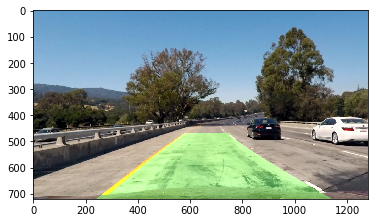

In [36]:
def drawFitPolyFromWarp(img, left_fitx, right_fitx, ploty, source_points, destination_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    newWarp = perspectiveWarp(warp_zero, destination_points, source_points)
    
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newWarp, 0.3, 0)

res = drawFitPolyFromWarp(test_img, left_fitx, right_fitx, ploty, source_points, destination_points)
plt.imshow(res)
cv2.imwrite('./output_images/lane_plotted.jpg', res[:, :, ::-1])

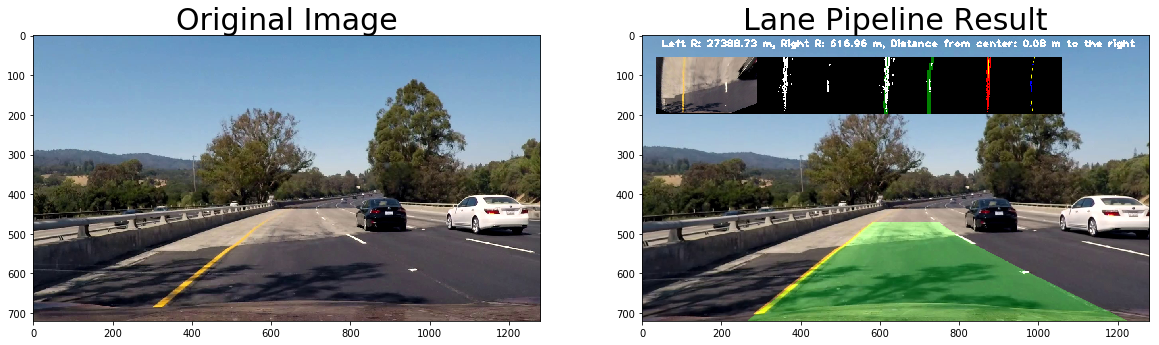

In [17]:
%matplotlib inline

THRESHS = dict(
    LINE_FILTER,
    **{
        'diffcr_max': 700,
        'cr_thresh': [0, 16000], # meters
        'width_thresh': [2.5, 4.5] # meters
    }
)

WINDOWS_P = {
    'window_width': 50, 
    'window_height': 80, # Break image into 9 vertical layers since image height is 720
    'margin': 80, # How much to slide left and right for searching
    'min_pixels': 50,
    'ratio_bottom': 1.0 / 2,
}

PERSPECTIVE_WARP_P = {
    'src': np.float32([(565, 470), (728, 470), (1110, 700), (226, 700)]),
    'dst': np.float32([(300, 0), (860, 0), (860,700), (300, 700)])
}

dist_pickle = pickle.load(open('camera_coeff.p', 'rb'))
mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

CALIBRATION_P = {
    'mtx': mtx,
    'dist': dist,
}

LANE_P = {
    'ym': 30/720, # meters per pixel in y dimension
    'xm': 3.7/700, # meters per pixel in x dimension
}

class LanePipeline():
    def __init__(self, lane_p = LANE_P, calib_p = CALIBRATION_P, prpt_warp_p = PERSPECTIVE_WARP_P, threshs = THRESHS, fit_p = WINDOWS_P):
        self.mtx = calib_p['mtx']
        self.dist = calib_p['dist']
        self.src_pts = prpt_warp_p['src']
        self.dst_pts = prpt_warp_p['dst']
        self.threshs = threshs
        self.xm_per_pix = lane_p['xm']
        self.ym_per_pix = lane_p['ym']
        self.left_fit = None
        self.right_fit = None
        self.l_windows = None
        self.r_windows = None
        self.l_nonzero = None
        self.r_nonzero = None
        self.tolerance_counter = 0
        self.window_width = fit_p['window_width']
        self.window_height = fit_p['window_height']
        self.margin = fit_p['margin']
        self.min_pixels = fit_p['min_pixels']
        self.ratio_bottom = fit_p['ratio_bottom']
    
    def validate(self, left_fit, right_fit, warp):
        # check curvature to make sure lines are relatively parallel
        y = warp.shape[0]
        left_cr = curvature(left_fit, y)
        right_cr = curvature(right_fit, y)
        if np.abs(left_cr - right_cr) > self.threshs['diffcr_max']:
            return False
        
        # check curvature within reasonable threshold
        if not within(left_cr, self.threshs['cr_thresh']):
            return False
        if not within(right_cr, self.threshs['cr_thresh']):
            return False
        
        # check distance from center
        dist = dist_from_center(left_fit, right_fit, warp.shape[0], warped.shape[1] / 2)
        if not within(dist, self.threshs['width_thresh']):
            return False
        ''
        # check lane width
        h_dist = lane_width(left_fit, right_fit, y)
        if not within(h_dist, self.threshs['width_thresh']):
            return False
        
        return True
    
    def nextLines(self, warped):
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Find nonzero points within a margin from fitted curves
        left_lane_inds = within(
            nonzerox, 
            [plugQuad(self.left_fit, nonzeroy) - self.margin, plugQuad(self.left_fit, nonzeroy) + self.margin]
        )

        right_lane_inds = within(
            nonzerox, 
            [plugQuad(self.right_fit, nonzeroy) - self.margin, plugQuad(self.right_fit, nonzeroy) + self.margin]
        )  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return left_fit, right_fit, left_lane_inds, right_lane_inds
    
    def processNew(self, warped):
        window_centroids = find_window_centroids(warped, self.window_width, self.window_height, self.margin, self.min_pixels, self.ratio_bottom)
        if len(window_centroids) > 0:
            self.l_windows, self.r_windows = centroids_to_windows(window_centroids, warped, self.window_width, self.window_height)
            try:
                self.left_fit, self.right_fit, self.l_nonzero, self.r_nonzero = windows_to_curves(self.l_windows, self.r_windows, warped)
            except:
                self.tolerance_counter += 1
                if self.tolerance_counter == 3:
                    self.reset()
                return False
            
            self.tolerance_counter = 0
            return True
        else:
            return False

    def processNext(self, warped):
        try:
            left_fit, right_fit, l_nonzero, r_nonzero = self.nextLines(warped)
        except:
            return False
        # check if we need to reset the fit, or we can continue the pipeline
        if self.validate(left_fit, right_fit, warped):
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.l_nonzero, self.r_nonzero = l_nonzero, r_nonzero
            self.tolerance_counter = 0
            return True
        return False
    
    def process(self, img):
        img = undistort(img, self.mtx, self.dist)
        warped = binaryWarp(img)
        warped = perspectiveWarp(warped, self.src_pts, self.dst_pts)
        warped = region_of_interest(warped)
        needNew = True
        if self.left_fit is not None and self.right_fit is not None:
            needNew = not self.processNext(warped)
        
        if needNew:
            if not self.processNew(warped):
                # Handle cases where we cannot find lane lines and
                # can potentially make constraints dynamic to find the lane lines in cases like this
                pass
        
        # Initialize as copy of image in case we cannot find any lines
        res = img.copy()
        if self.left_fit is not None and self.right_fit is not None:
            # Draw lane and overlay onto image
            ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
            left_fitx = plugQuad(self.left_fit, ploty)
            right_fitx = plugQuad(self.right_fit, ploty)
            res = drawFitPolyFromWarp(img, left_fitx, right_fitx, ploty, self.src_pts, self.dst_pts)
            
            # Overlay for debugging
            pers_sm = cv2.resize(perspectiveWarp(img, self.src_pts, self.dst_pts), None, fx = 0.2, fy = 0.2)
            
            warped_sm = cv2.resize(warped, None, fx = 0.2, fy = 0.2)
            warped_sm = np.dstack((warped_sm, ) * 3) * 255
            
            template = np.array(self.r_windows + self.l_windows,np.uint8) # add both left and right window pixels together
            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.array(np.dstack((zero_channel,template,zero_channel)),np.uint8) * 255 # make window pixels green
            warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
            window_overlay = cv2.addWeighted(np.uint8(warpage), 1, template, 0.5, 0.0) # overlay the orignal road image with window results
            window_overlay = cv2.resize(window_overlay, None, fx = 0.2, fy = 0.2)
    
            plot_overlay = np.zeros(warped.shape[:2] + (3,), dtype = np.uint8)
            plot_overlay[self.l_nonzero[0], self.l_nonzero[1]] = [255, 0, 0]
            plot_overlay[self.r_nonzero[0], self.r_nonzero[1]] = [0, 0, 255]
            line_points = np.array((np.vstack((left_fitx, ploty)).T, np.vstack((right_fitx, ploty)).T), dtype=np.int32)
            cv2.polylines(plot_overlay, line_points, False, [255, 255, 0], thickness=2, lineType=cv2.LINE_AA)
            plot_overlay = cv2.resize(plot_overlay, None, fx = 0.2, fy = 0.2)
            
            y_offset = warped_sm.shape[0]
            x_offset = warped_sm.shape[1]
            overlays = [pers_sm, warped_sm, window_overlay, plot_overlay]
            for i, overlay in enumerate(overlays):
                res[55: 55 + y_offset, 35 + x_offset * i: 35 + x_offset * (i + 1)] = overlay
            

            dist = dist_from_center(self.left_fit, self.right_fit, np.max(ploty), warped.shape[1] / 2)
            left_cr = curvature(self.left_fit, img.shape[0])
            right_cr = curvature(self.right_fit, img.shape[0])

            # Display curvature and distance from lane center
            cv2.putText(
                res, 
                'Left R: {0:.2f} m, Right R: {1:.2f} m, Distance from center: {2:.2f} m to the {3}'.format(
                    left_cr,
                    right_cr,
                    np.abs(dist),
                    'left' if dist < 0 else 'right'
                ),
                (50, 30),
                cv2.FONT_HERSHEY_PLAIN,
                1.7,
                (255, 255, 255),
                thickness = 3,
            )
        return res
    
    def reset(self):
        self.left_fit = self.right_fit = None
        self.tolerance_counter = 0


pipeline = LanePipeline()
test_img = plt.imread('test_images/project_video1.jpg')

# Plot the binary warped result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(pipeline.process(test_img))
ax2.set_title('Lane Pipeline Result', fontsize=30)

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline = LanePipeline()
project_vid = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(pipeline.process) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(project_vid, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:49<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 6s, sys: 33.7 s, total: 10min 40s
Wall time: 5min 50s
